# Selección de modelo



In [1]:
# Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print('\nVariables de entrada (X):')
print(X.info())
print('-' * 92)
print('\nVariable dependiente (Y):')
print(Y.info())
print(Y.value_counts().sort_index())


Variables de entrada (X):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25674 entries, 0 to 25673
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   EDAD                                 25674 non-null  float64
 1   DIAMETRO                             25674 non-null  float64
 2   LONGITUD                             25674 non-null  float64
 3   AREA                                 25674 non-null  float64
 4   PROF_BATEA                           25674 non-null  float64
 5   PROF_BATE1                           25674 non-null  float64
 6   PENDIENTE                            25674 non-null  float64
 7   TIPO_AGUA_COMBINADAS                 25674 non-null  bool   
 8   TIPO_AGUA_LLUVIAS Y DESCARGAS        25674 non-null  bool   
 9   TIPO_AGUA_OTRAS                      25674 non-null  bool   
 10  MATERIAL_CONCRETO REFORZADO Y OTROS  25674 non-null  bool   
 11  M

# Verificar balance de variable dependiente

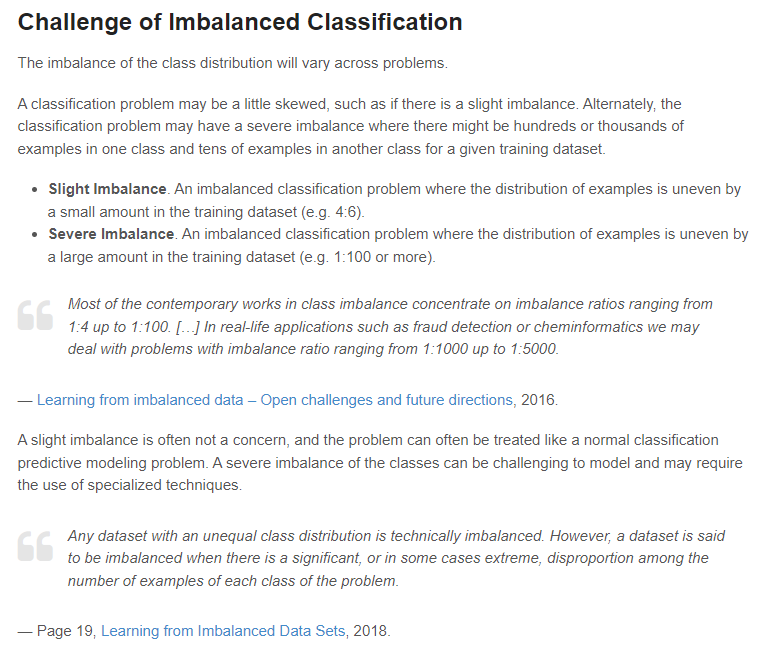

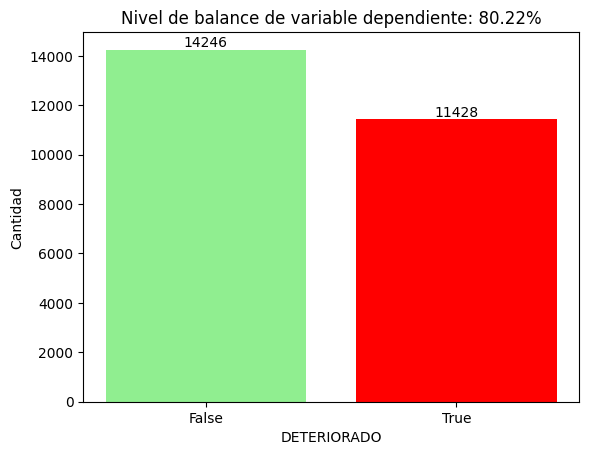

In [4]:
# Verificar balanceo de clase objetivo

conteo = Y.value_counts()
balance = (min(conteo) / max(conteo))
PESOS_DE_CLASE = {False: 1, True: 2}

plt.bar(conteo.index.astype(str), conteo.values, color=['lightgreen', 'red'])
for i, valor in enumerate(conteo.values):
    plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom')

plt.xlabel('DETERIORADO')
plt.ylabel('Cantidad')
plt.title(f'Nivel de balance de variable dependiente: {balance:.2%}')
plt.show()

# Crear estructuras para almacenar modelos y sus resultados

In [5]:
# Definir clase para evaluación de modelos

class EvaluacionModeloML:
    def __init__(self, modelo, param_grid={}):
        self.modelo = modelo
        self.param_grid = param_grid
        self.best_params = {}
        self.scoresCV = None # Para resultados de cross_validate


# Configurar modelos candidatos

## Crear cada modelo a evaluar

In [6]:
# Diccionario de evaluaciones
dict_evaluaciones = {}

In [7]:
# Regresión logística Newton-Cholesky

dict_evaluaciones['LGR-nc'] = EvaluacionModeloML(
    modelo = LogisticRegression(),
    param_grid = {
        'C'                      : [1, 0.1, 5],
        'class_weight'           : [PESOS_DE_CLASE],
        #'dual'                   : [False, True, ],
        #'fit_intercept'          : [True, False, ],
        #'intercept_scaling'      : [1, 0.1, 10, ],
        #'l1_ratio'               : [None, ],
        'max_iter'               : [10000, ],
        #'multi_class'            : ['auto', ],
        'n_jobs'                 : [-1],
        'penalty'                : ['l2', 'l1', 'elasticnet', None],
        'solver'                 : ['newton-cholesky', 'newton-cg' , 'saga'],
        #'tol'                    : [0.0001, 1e-05, 0.001, ],
    }
)

#dict_evaluaciones["LGR"].best_params = {'C': 1, 'max_iter': 5000, 'n_jobs': -1, 'solver': 'newton-cholesky'}
#dict_evaluaciones["LGR"].best_params = {'C': 0.1, 'class_weight': PESOS_DE_CLASE, 'max_iter': 10000, 'n_jobs': -1, 'solver': 'saga'}

# despues de pesos 
dict_evaluaciones["LGR-nc"].best_params    = {'C': 5, 'class_weight': PESOS_DE_CLASE, 'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cholesky'}

In [8]:
# Regresión logística Newton-CG

dict_evaluaciones['LGR-cg'] = EvaluacionModeloML(
    modelo = LogisticRegression(),
    param_grid = {
        'C'                      : [1, 0.1, 5],
        'class_weight'           : [PESOS_DE_CLASE],
        #'dual'                   : [False, True, ],
        #'fit_intercept'          : [True, False, ],
        #'intercept_scaling'      : [1, 0.1, 10, ],
        #'l1_ratio'               : [None, ],
        'max_iter'               : [10000, ],
        #'multi_class'            : ['auto', ],
        'n_jobs'                 : [-1],
        'penalty'                : ['l2', 'l1', 'elasticnet', None],
        'solver'                 : ['newton-cholesky', 'newton-cg' , 'saga'],
        #'tol'                    : [0.0001, 1e-05, 0.001, ],
    }
)

dict_evaluaciones["LGR-cg"].best_params = {'C': 1, 'class_weight': PESOS_DE_CLASE, 'max_iter': 10000, 'n_jobs': -1, 'penalty': None, 'solver': 'newton-cg'}

In [9]:
dict_evaluaciones['LSVC'] = EvaluacionModeloML(
    modelo = LinearSVC(),
    param_grid = {
    	'C'                      : [1.0, 0.1, 5 ],
    	'class_weight'           : [PESOS_DE_CLASE],
    	'dual'                   : [True, False],
    	'fit_intercept'          : [True, False, ],
    	'intercept_scaling'      : [1, 0.1, 5, ],
    	'loss'                   : ['squared_hinge', 'hinge'],
    	'max_iter'               : [20000],
    	#'multi_class'            : ['ovr', ],
    	'penalty'                : ['l2', 'l1'],
    	#'tol'                    : [0.0001, 1e-05, 0.001, ],
    }
)

#dict_evaluaciones["LSVC"].best_params = {'C': 5, 'class_weight': None, 'dual': True, 'fit_intercept': False, 'intercept_scaling': 0.1, 'loss': 'hinge', 'max_iter': 5000, 'penalty': 'l2'}
#dict_evaluaciones["LSVC"].best_params = {'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 20000, 'loss': 'hinge', 'intercept_scaling': 5, 'fit_intercept': True, 'dual': True, 'class_weight': PESOS_DE_CLASE, 'C': 0.1}

# despues de pesos
dict_evaluaciones["LSVC"].best_params = {'C': 0.1, 'class_weight': PESOS_DE_CLASE, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 50000, 'penalty': 'l2'}


In [10]:
# Hist Gradient booster classifier

dict_evaluaciones['HGBC'] = EvaluacionModeloML(
    modelo = HistGradientBoostingClassifier(),
    param_grid = {
        #'categorical_features'   : [None, ],
        'class_weight'           : [PESOS_DE_CLASE],
        'interaction_cst'        : [None, 'pairwise'],
        #'l2_regularization'      : [0.0, ],
        'learning_rate'          : [0.1, 0.01,],
        #'loss'                   : ['log_loss', ],
        #'max_bins'               : [255, 25.5, 2550, ],
        #'max_depth'              : [None, ],
        'max_iter'               : [1000, ],
        #'max_leaf_nodes'         : [31, None, ],
        #'min_samples_leaf'       : [20, 50, ],
        #'monotonic_cst'          : [None, ],
        #'n_iter_no_change'       : [10, 1.0, 100, ],
        #'scoring'                : ['loss', ],
        #'tol'                    : [1e-07, 1e-08, 1e-06, ],
        #'validation_fraction'    : [0.1, 0.01, 1.0, ],
    }
)

#dict_evaluaciones["HGBC"].best_params = {'interaction_cst': 'pairwise', 'learning_rate': 0.01, 'max_iter': 1000, 'max_leaf_nodes': 31, 'min_samples_leaf': 20}
dict_evaluaciones["HGBC"].best_params = {'class_weight': PESOS_DE_CLASE, 'interaction_cst': 'pairwise', 'learning_rate': 0.01, 'max_iter': 1000}


In [11]:
# Random Forest Classifier

dict_evaluaciones['RFC'] = EvaluacionModeloML(
    modelo = RandomForestClassifier(),
    param_grid = {
        #'bootstrap'              : [True, False, ],
        #'ccp_alpha'              : [0.0, 1.0],
        'class_weight'           : [PESOS_DE_CLASE],
        'criterion'              : ['gini', 'entropy', 'log_loss'],
        #'max_depth'              : [None, ],
        'max_features'           : ['sqrt', None],
        #'max_leaf_nodes'         : [None, ],
        #'max_samples'            : [None, ],
        #'min_impurity_decrease'  : [0.0, ],
        'min_samples_leaf'       : [1, 5, ],
        #'min_samples_split'      : [2, ],
        #'min_weight_fraction_leaf': [0.0, ],
        'n_estimators'           : [2000, ],
        'n_jobs'                 : [-1, ],
        #'oob_score'              : [False, True, ],
    }
)

dict_evaluaciones["RFC"].best_params = {'class_weight': PESOS_DE_CLASE, 'criterion': 'entropy', 'n_estimators': 2000, 'n_jobs': -1}


In [12]:
# Red neuronal

dict_evaluaciones['MLP'] = EvaluacionModeloML(
    modelo = MLPClassifier(),
    param_grid = {
        'activation'             : ['relu', 'tanh', ],
        # 'alpha'                  : [0.0001, 1e-05, 0.001, ],
        # 'batch_size'             : ['auto', ],
        # 'beta_1'                 : [0.9, 0.09, 9.0, ],
        # 'beta_2'                 : [0.999, 0.0999, 9.99, ],
        # 'epsilon'                : [1e-08, 1e-09, 1e-07, ],
        'hidden_layer_sizes'     : [(100,), (64, 64, 64)],
        # 'learning_rate'          : ['constant', ],
        'learning_rate_init'     : [0.001, 0.0001, ],
        # 'max_fun'                : [15000, 1500.0, 150000, ],
        'max_iter'               : [5000, ],
        # 'momentum'               : [0.9, 0.09, 9.0, ],
        # 'n_iter_no_change'       : [10, 1.0, 100, ],
        # 'nesterovs_momentum'     : [True, False, ],
        # 'power_t'                : [0.5, 0.05, 5.0, ],
        'solver'                 : ['adam', 'sgd', 'lbfgs'],
        # 'tol'                    : [0.0001, 1e-05, 0.001, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
    }
)

dict_evaluaciones["MLP"].best_params = {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 10000, 'solver': 'sgd'}


In [13]:
# Gradient booster

dict_evaluaciones['GBC'] = EvaluacionModeloML(
    modelo = GradientBoostingClassifier(),
    param_grid = {
    	# 'ccp_alpha'              : [0.0, ],
    	# 'criterion'              : ['friedman_mse', 'squared_error'],
    	# 'init'                   : [None, 'zero'],
    	'learning_rate'          : [0.1, 0.01, ],
    	# 'loss'                   : ['log_loss', 'exponential'],
    	'max_depth'              : [10, None],
    	# 'max_features'           : [None, 'sqrt' ],
    	# 'max_leaf_nodes'         : [None, ],
    	# 'min_impurity_decrease'  : [0.0, ],
    	# 'min_samples_leaf'       : [1, 0.1, 10, ],
    	# 'min_samples_split'      : [2, 0.2, 20, ],
    	# 'min_weight_fraction_leaf': [0.0, ],
    	'n_estimators'           : [500],
    	# 'n_iter_no_change'       : [None, ],
    	# 'subsample'              : [1.0, 0.5, ],
    	# 'tol'                    : [0.0001, 1e-05, 0.001, ],
    	# 'validation_fraction'    : [0.1, 0.01, 1.0, ],
    }
)

dict_evaluaciones["GBC"].best_params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}


## Búsqueda de hiperparámetros de cada modelo

In [14]:
# Conjuntos de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y)

print('Cálculo de hiperparámetros')
print('-' * 80)
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{nombre}')
    if evaluacion.best_params == {}: # Recalcular solo si es nuevo
        searchCV = GridSearchCV(
            evaluacion.modelo, evaluacion.param_grid,
            cv=5, scoring='recall', verbose=5,
            n_jobs=-1, 
            #n_iter=10,
        )
        searchCV.fit(x_train, y_train)
        evaluacion.best_params = searchCV.best_params_
        print()

    evaluacion.modelo.set_params(**evaluacion.best_params)
    print(f'Modelo:', evaluacion.modelo)
    print(evaluacion.best_params)
    print('-' * 80)


Cálculo de hiperparámetros
--------------------------------------------------------------------------------
LGR-nc
Modelo: LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, solver='newton-cholesky')
{'C': 5, 'class_weight': {False: 1, True: 2}, 'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cholesky'}
--------------------------------------------------------------------------------
LGR-cg
Modelo: LogisticRegression(C=1, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, penalty=None, solver='newton-cg')
{'C': 1, 'class_weight': {False: 1, True: 2}, 'max_iter': 10000, 'n_jobs': -1, 'penalty': None, 'solver': 'newton-cg'}
--------------------------------------------------------------------------------
LSVC
Modelo: LinearSVC(C=0.1, class_weight={False: 1, True: 2}, dual=False,
          fit_intercept=False, max_iter=50000)
{'C': 0.1, 'class_weight': {False: 1, True: 2}, 'dual': False, 'f

# Validación cruzada (*cross-validation*)

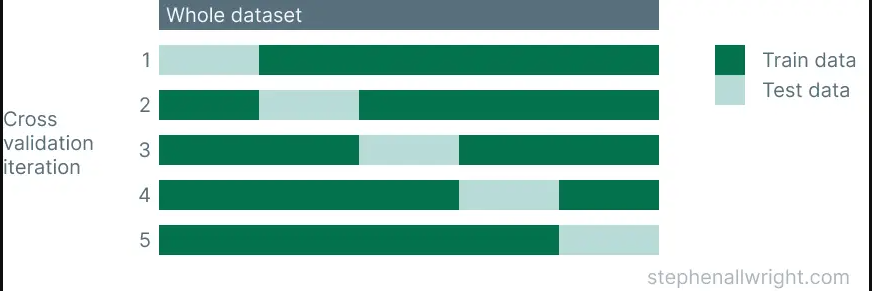

## Evaluación de rendimiento de cada modelo.

Se usa el conjunto de datos completo.

In [15]:
print('Rendimiento de cada modelo')
forzar_calculo = False
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{"-" * 100}')
    print(evaluacion.modelo)
    if forzar_calculo | (not evaluacion.scoresCV):
        print('Calculando...')
        evaluacion.scoresCV = cross_validate(
            estimator=evaluacion.modelo,
            X=X, y=Y, 
            cv=10, 
            scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
            verbose=3,
            n_jobs=-1,
        )
        print()

    df_scoresCV = pd.DataFrame(evaluacion.scoresCV)
    #print(df_scoresCV)
    #print('\nPromedios:')
    print(df_scoresCV.mean())

Rendimiento de cada modelo
----------------------------------------------------------------------------------------------------
LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, solver='newton-cholesky')
Calculando...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          0.107485
score_time        0.016119
test_accuracy     0.738023
test_f1           0.738502
test_precision    0.669658
test_recall       0.831726
test_roc_auc      0.815349
dtype: float64
----------------------------------------------------------------------------------------------------
LogisticRegression(C=1, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, penalty=None, solver='newton-cg')
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          0.469297
score_time        0.014343
test_accuracy     0.738101
test_f1           0.738535
test_precision    0.669775
test_recall       0.831638
test_roc_auc      0.815363
dtype: float64
----------------------------------------------------------------------------------------------------
LinearSVC(C=0.1, class_weight={False: 1, True: 2}, dual=False,
          fit_intercept=False, max_iter=50000)
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          0.549912
score_time        0.015346
test_accuracy     0.738062
test_f1           0.738465
test_precision    0.669373
test_recall       0.831814
test_roc_auc      0.815226
dtype: float64
----------------------------------------------------------------------------------------------------
HistGradientBoostingClassifier(class_weight={False: 1, True: 2},
                               interaction_cst='pairwise', learning_rate=0.01,
                               max_iter=1000)
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.9s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          4.855353
score_time        0.362267
test_accuracy     0.737869
test_f1           0.737682
test_precision    0.670229
test_recall       0.829711
test_roc_auc      0.805875
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForestClassifier(class_weight={False: 1, True: 2}, criterion='entropy',
                       n_estimators=2000, n_jobs=-1)
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.1min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.1min remaining:   54.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          102.815835
score_time         22.509851
test_accuracy       0.723300
test_f1             0.683803
test_precision      0.698994
test_recall         0.682966
test_roc_auc        0.780660
dtype: float64
----------------------------------------------------------------------------------------------------
MLPClassifier(activation='tanh', max_iter=10000, solver='sgd')
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.2s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   10.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



fit_time          10.197006
score_time         0.027285
test_accuracy      0.751539
test_f1            0.724302
test_precision     0.722655
test_recall        0.738967
test_roc_auc       0.815895
dtype: float64
----------------------------------------------------------------------------------------------------
GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=500)
Calculando...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.8min remaining:   46.5s



fit_time          108.468225
score_time          0.148337
test_accuracy       0.722638
test_f1             0.689253
test_precision      0.691205
test_recall         0.699679
test_roc_auc        0.778248
dtype: float64


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


# Visualizar métricas de modelos

In [16]:
# Generar tabla de métricas

data = {}
model_names = []
for nombre, evaluacion in dict_evaluaciones.items():
    scores = evaluacion.scoresCV
    model_names.append(nombre)
    data[nombre] = [
        scores['test_accuracy'].mean(),
        scores['test_f1'].mean(),
        scores['test_precision'].mean(),
        scores['test_recall'].mean(),
        scores['test_roc_auc'].mean(),        
    ]

df = pd.DataFrame(
    data,
    index=[
        'test_accuracy',
        'test_f1',
        'test_precision',
        'test_recall',
        'test_roc_auc',
    ]
)

df_normalized = pd.DataFrame(df.T, columns=df.index)

In [17]:
# Visualizar tabla

df_tabla_metricas = df_normalized.reset_index()
df_tabla_metricas.rename(
    columns={
        'index'          : 'MODELO',
        'test_accuracy'  : 'ACCURACY',
        'test_f1'        : 'F1',
        'test_precision' : 'PRECISION',
        'test_recall'    : 'RECALL',
        'test_roc_auc'   : 'ROC_AUC',
    },
    inplace=True,
)

print(df_tabla_metricas)

   MODELO  ACCURACY        F1  PRECISION    RECALL   ROC_AUC
0  LGR-nc  0.738023  0.738502   0.669658  0.831726  0.815349
1  LGR-cg  0.738101  0.738535   0.669775  0.831638  0.815363
2    LSVC  0.738062  0.738465   0.669373  0.831814  0.815226
3    HGBC  0.737869  0.737682   0.670229  0.829711  0.805875
4     RFC  0.723300  0.683803   0.698994  0.682966  0.780660
5     MLP  0.751539  0.724302   0.722655  0.738967  0.815895
6     GBC  0.722638  0.689253   0.691205  0.699679  0.778248


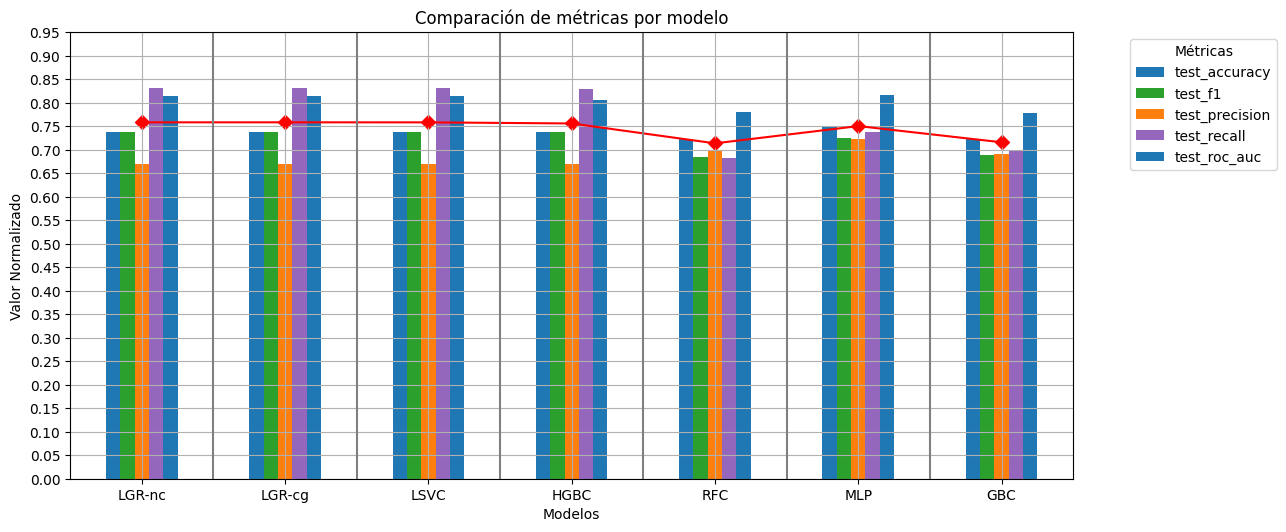

In [18]:
# Visualizar gráfico de barras comparativo


# Crear el gráfico de barras agrupadas por modelo y métricas
ax = df_normalized.plot(kind='bar', figsize=(14, 5), color= ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd'])
ax.set_xticklabels(model_names, rotation=0, ha="center")

legend = ax.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75) # Asegurarse de que la leyenda se ajuste adecuadamente

# Calcular los promedios y agregar los diamantes sobre los grupos de barras
averages = df_normalized.mean(axis=1)

# Definir los pesos para cada métrica
#weights = np.array([1,1,1,1])
# Calcular el promedio ponderado usando los pesos
#averages = df_normalized.dot(weights)

for i, avg in enumerate(averages):
    plt.scatter(i, avg, marker='D', color='red', s=50)

# Trazar la línea que une los puntos promedio
plt.plot(averages.index, averages.values, marker='o', linestyle='-', color='red')

# Agregar líneas entre los promedios de cada grupo
for i in range(1, len(model_names)):
    plt.axvline(x=i-0.5, color='gray', linestyle='-')

plt.yticks(np.arange(0, 1, 0.05))

plt.title('Comparación de métricas por modelo')
plt.xlabel('Modelos')
plt.ylabel('Valor Normalizado')
plt.grid()
plt.show()


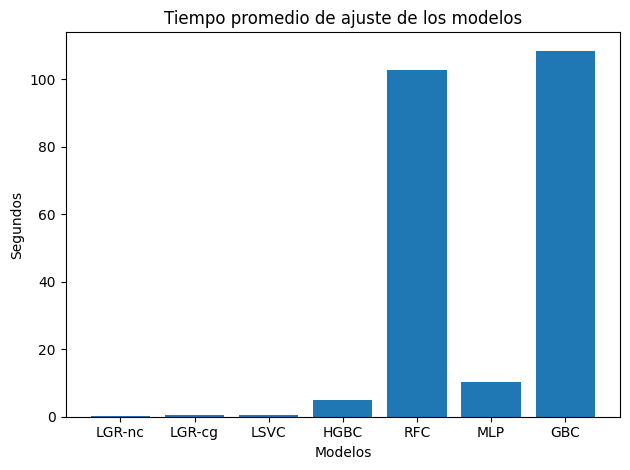

In [19]:
# Visualizar tiempos de ajuste

tiempos = [evaluacion.scoresCV['fit_time'].mean() for evaluacion in dict_evaluaciones.values()]
nombres = dict_evaluaciones.keys()

plt.bar(range(len(nombres)), tiempos)
plt.xticks(range(len(nombres)), nombres)
plt.xlabel('Modelos')
plt.ylabel('Segundos')
plt.title('Tiempo promedio de ajuste de los modelos')
plt.tight_layout()
plt.show()

## Precision vs Recall

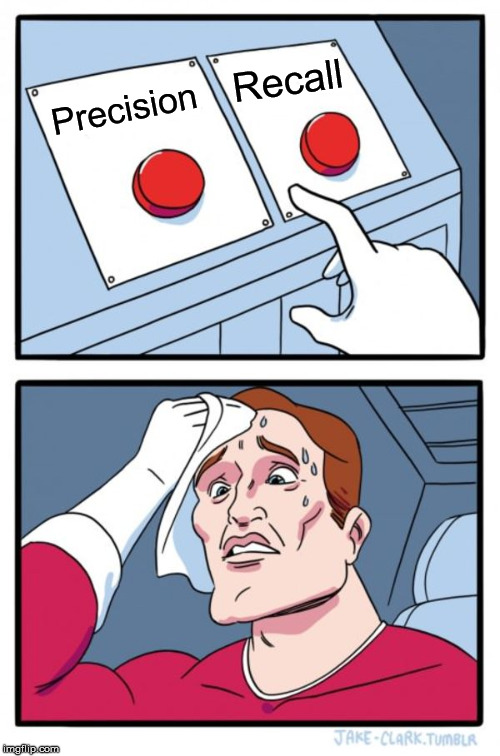

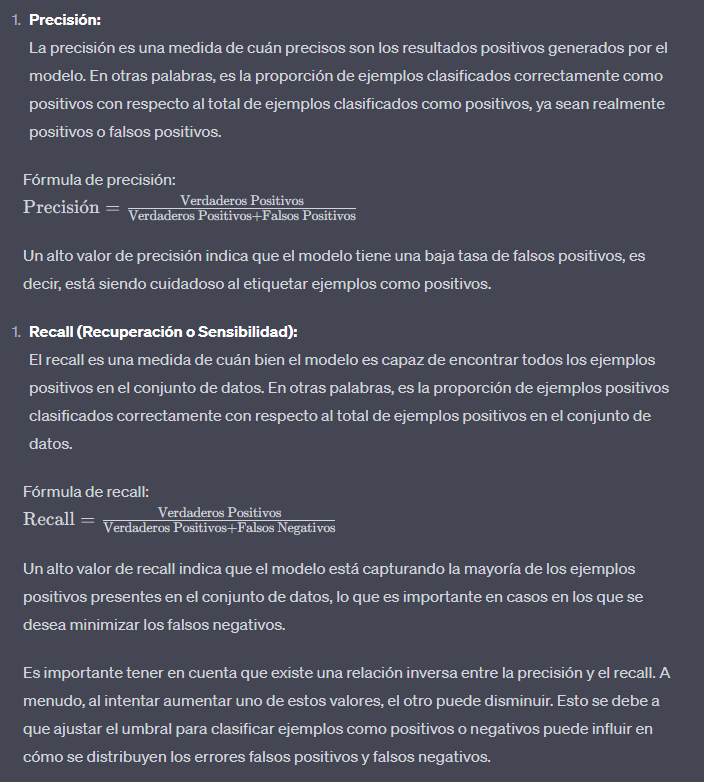

Precisionrecall.svg

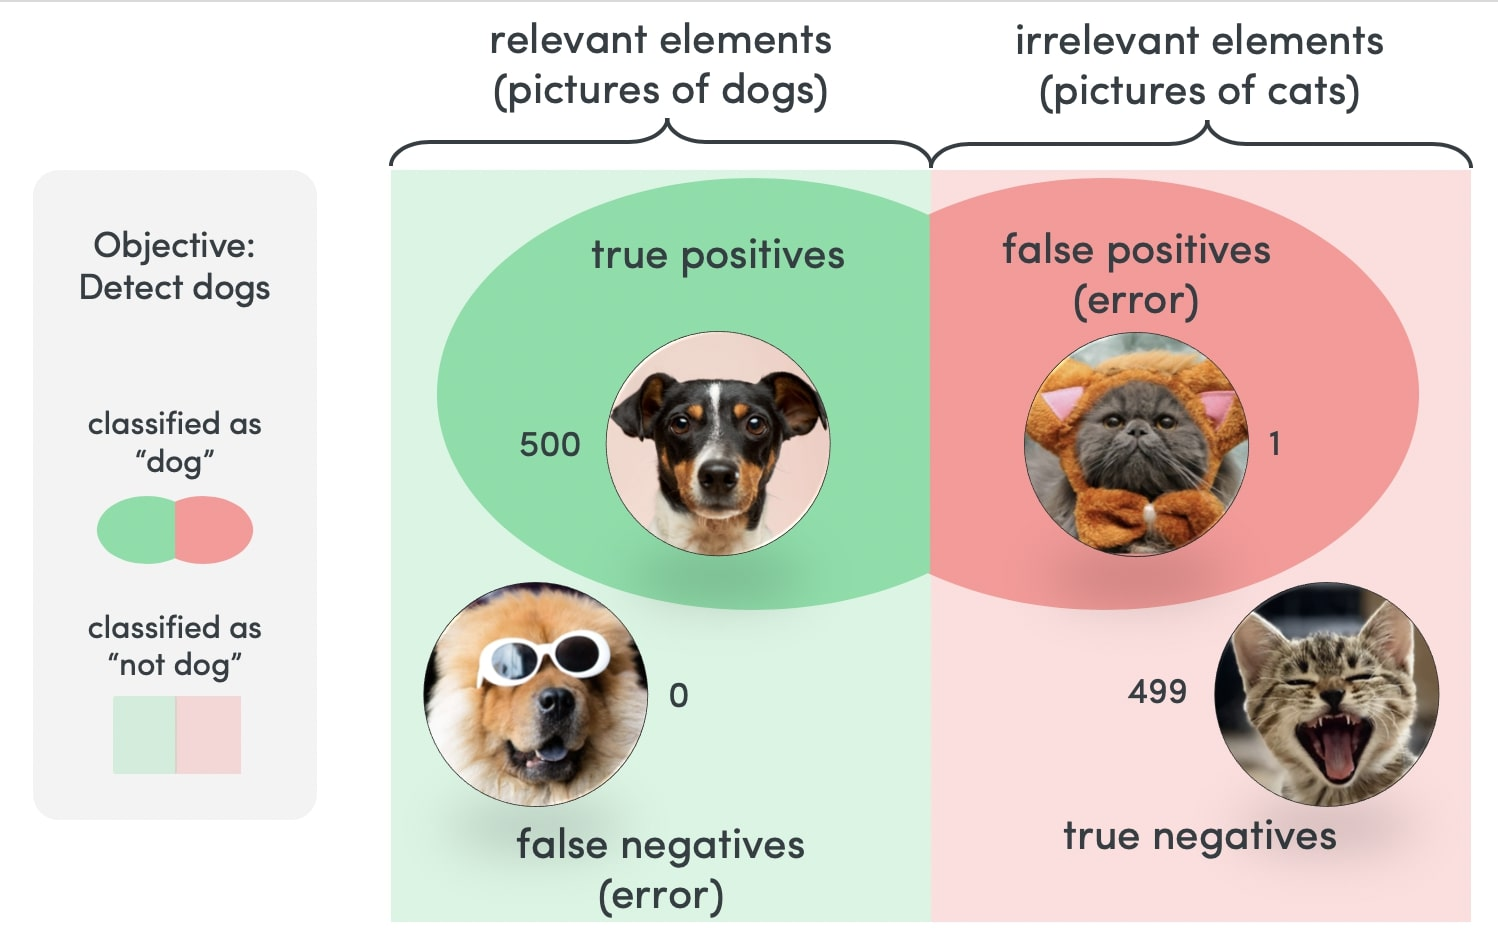

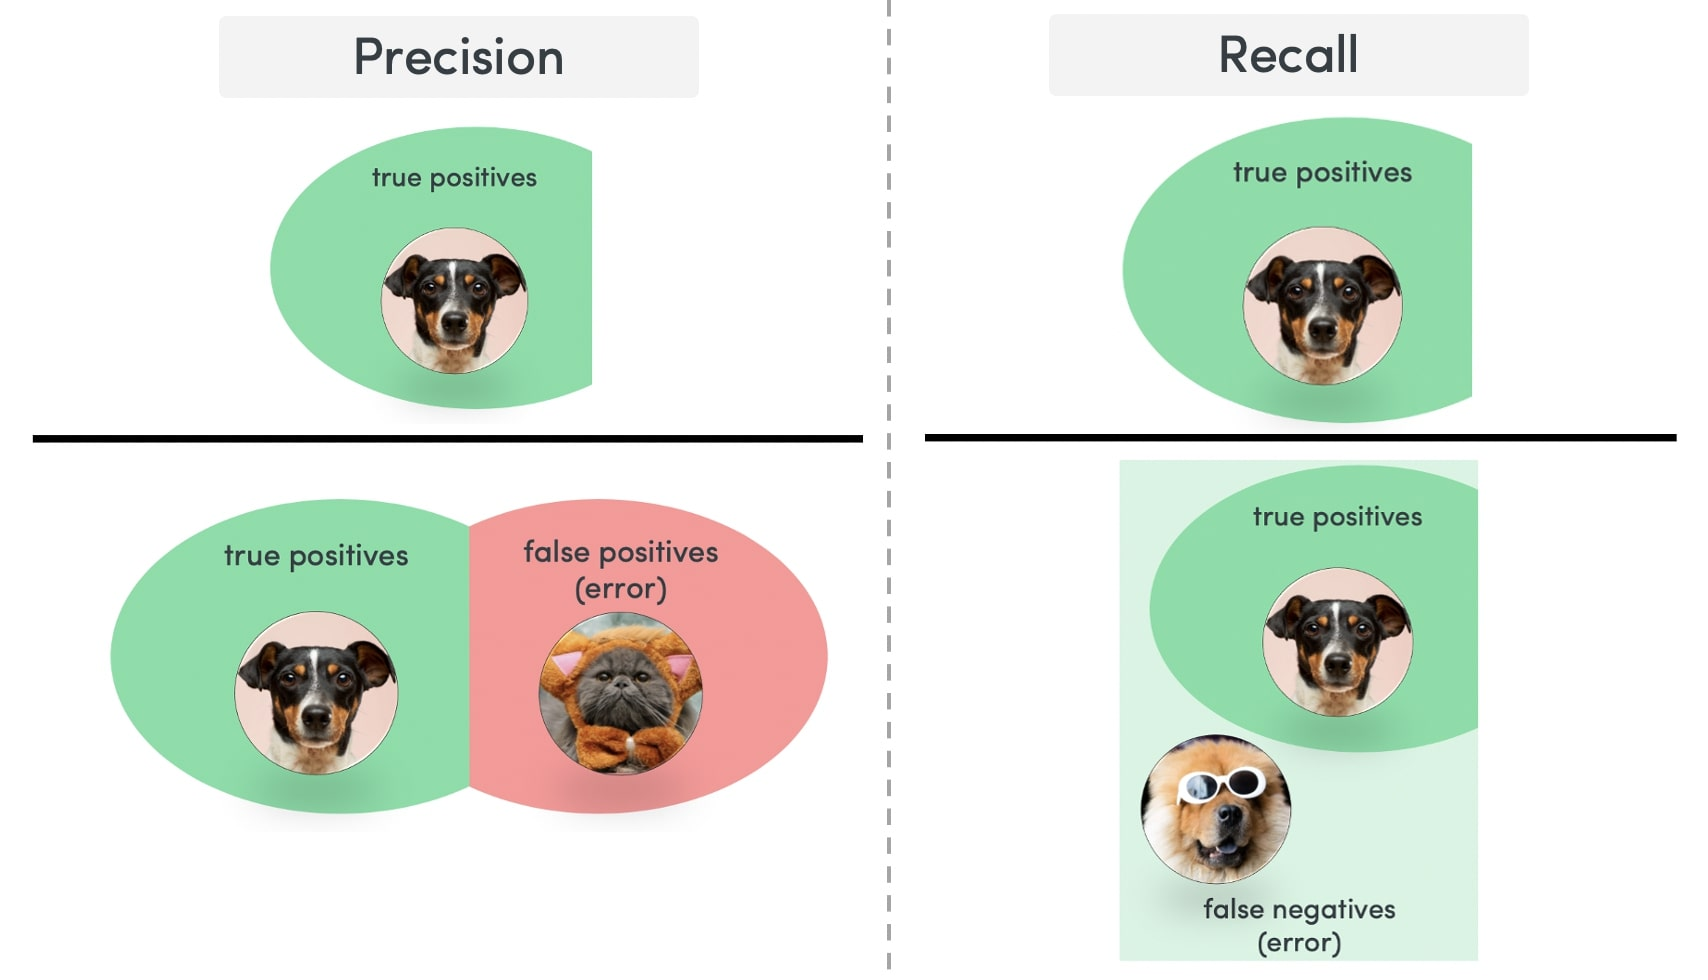

In [20]:
for nombre, evaluacion in dict_evaluaciones.items():
    print('-' * 120)
    print(evaluacion.modelo)
    print(f'\ndict_evaluaciones["{nombre}"].best_params = {evaluacion.best_params}')

------------------------------------------------------------------------------------------------------------------------
LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, solver='newton-cholesky')

dict_evaluaciones["LGR-nc"].best_params = {'C': 5, 'class_weight': {False: 1, True: 2}, 'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cholesky'}
------------------------------------------------------------------------------------------------------------------------
LogisticRegression(C=1, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, penalty=None, solver='newton-cg')

dict_evaluaciones["LGR-cg"].best_params = {'C': 1, 'class_weight': {False: 1, True: 2}, 'max_iter': 10000, 'n_jobs': -1, 'penalty': None, 'solver': 'newton-cg'}
------------------------------------------------------------------------------------------------------------------------
LinearSVC(C=0.1, class_weight={False: 1